# Artificial Intelligence in Finance

## Risk Management

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## Trading Bot

In [2]:
import finance
import tradingbot

In [3]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [4]:
a = 0
b = 1750
c = 250

In [5]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                 leverage=1, min_performance=0.9, min_accuracy=0.475,
                 start=a, end=a + b, mu=None, std=None)

In [6]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 88.9 KB


In [7]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [8]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 12.7 KB


In [9]:
tradingbot.set_seeds(100)
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [10]:
episodes = 61

In [11]:
%time agent.learn(episodes)

C:\Users\Public\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode: 10/61 | VALIDATION | treward:  247 | perf: 0.955 | eps: 0.95
episode: 20/61 | VALIDATION | treward:  247 | perf: 0.992 | eps: 0.86
episode: 30/61 | VALIDATION | treward:  247 | perf: 1.114 | eps: 0.78
episode: 40/61 | VALIDATION | treward:  247 | perf: 0.989 | eps: 0.70
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.954 | eps: 0.64
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.916 | eps: 0.58
episode: 61/61 | treward:   16 | perf: 0.997 | av:  92.3 | max: 1747
Wall time: 1min 44s


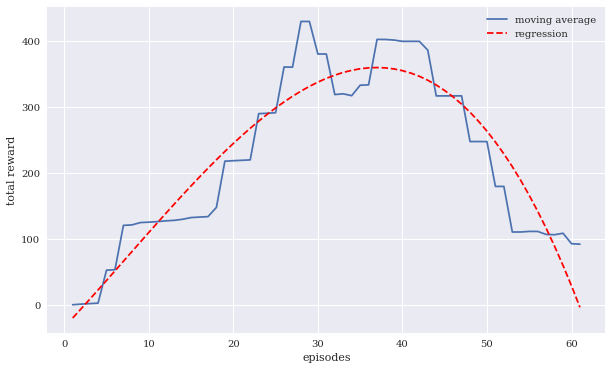

In [12]:
tradingbot.plot_treward(agent)

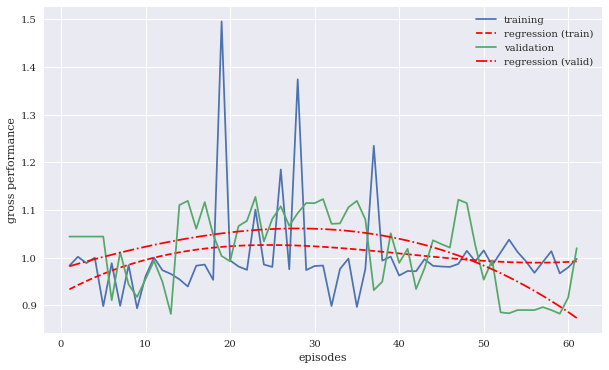

In [13]:
tradingbot.plot_performance(agent)

## Vectorized Backtesting

In [ ]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [ ]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state))[0, 0])
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [ ]:
env = agent.learn_env

In [ ]:
backtest(agent, env)

In [ ]:
env.data['p'].iloc[env.lags:].value_counts()

In [ ]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

In [ ]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

In [ ]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [ ]:
env = test_env

In [ ]:
backtest(agent, env)

In [ ]:
env.data['p'].iloc[env.lags:].value_counts()

In [ ]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

In [ ]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

In [ ]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

## Event-Based Backtesting

In [ ]:
import backtesting as bt

In [ ]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0,
                        verbose=True) 

In [ ]:
bb.initial_amount

In [ ]:
bar = 100

In [ ]:
bb.get_date_price(bar)

In [ ]:
bb.env.get_state(bar)

In [ ]:
bb.place_buy_order(bar, amount=5000)

In [ ]:
bb.print_net_wealth(2 * bar)

In [ ]:
bb.place_sell_order(2 * bar, units=1000)

In [ ]:
bb.close_out(3 * bar)

In [ ]:
class TBBacktester(bt.BacktestingBase):
    def _reshape(self, state):
        ''' Helper method to reshape state objects.
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])
    def backtest_strategy(self):
        ''' Event-based backtesting of the trading bot's performance.
        '''
        self.units = 0
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')
            state = self.env.get_state(bar)
            action = np.argmax(self.model.predict(
                        self._reshape(state.values))[0, 0])
            position = 1 if action == 1 else -1
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1,
                                     amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1,
                                      amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            self.net_wealths.append((date,
                                     self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths,
                                        columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(
                                        self.net_wealths.index)
        self.close_out(bar)

In [ ]:
env = learn_env

In [ ]:
tb = TBBacktester(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [ ]:
tb.backtest_strategy()

In [ ]:
tb_ = TBBacktester(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [ ]:
tb_.backtest_strategy()

In [ ]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

In [ ]:
env = test_env

In [ ]:
tb = TBBacktester(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [ ]:
tb.backtest_strategy()

In [ ]:
tb_ = TBBacktester(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [ ]:
tb_.backtest_strategy()

In [ ]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

In [ ]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax);

## Assessing Risk

In [ ]:
data = pd.DataFrame(learn_env.data[symbol])

In [ ]:
data.head()

In [ ]:
window = 14

In [ ]:
data['min'] = data[symbol].rolling(window).min()

In [ ]:
data['max'] = data[symbol].rolling(window).max()

In [ ]:
data['mami'] = data['max'] - data['min']

In [ ]:
data['mac'] = abs(data['max'] - data[symbol].shift(1))

In [ ]:
data['mic'] = abs(data['min'] - data[symbol].shift(1))

In [ ]:
data['atr'] = np.maximum(data['mami'], data['mac'])

In [ ]:
data['atr'] = np.maximum(data['atr'], data['mic'])

In [ ]:
data['atr%'] = data['atr'] / data[symbol]

In [ ]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6));

In [ ]:
data[['atr', 'atr%']].tail()

In [ ]:
leverage = 10

In [ ]:
data[['atr', 'atr%']].tail() * leverage

In [ ]:
data[['atr', 'atr%']].median() * leverage

## Backtesting Risk Measures

In [ ]:
import tbbacktesterrm as tbbrm

In [ ]:
env = test_env

In [ ]:
tb = tbbrm.TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0, verbose=False)

In [ ]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

### Stop Loss

In [ ]:
tb.backtest_strategy(sl=0.0175, tsl=None, tp=None,
                     wait=5, guarantee=False)

In [ ]:
tb.backtest_strategy(sl=0.017, tsl=None, tp=None,
                     wait=5, guarantee=True)

### Trailing Stop Loss

In [ ]:
tb.backtest_strategy(sl=None, tsl=0.015,
                     tp=None, wait=5)

### Take Profit

In [ ]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=False)

In [ ]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.015,
                     wait=5, guarantee=True)

## Combinations

In [ ]:
tb.backtest_strategy(sl=0.015, tsl=None,
                     tp=0.0185, wait=5)

In [ ]:
tb.backtest_strategy(sl=None, tsl=0.02,
                     tp=0.02, wait=5)

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>